In [1]:
import Pkg
Pkg.activate("../Tasks2D")

  Activating project at `~/Developer/tasks2D/Tasks2D`


In [2]:
using Revise      # For development; makes it so modifications
                  # to imported modules are immediately reflected in this Julia session

import LineWorlds # Local module with code for 2D maps where
                  # the primitive objects are line segments.
const L = LineWorlds
const Geo = L.Geometry;

In [3]:
using Gen

In [4]:
includet("KidnappedRobot/visualization.jl")

## Define environment model

In [5]:
### Initial state distribution ###

mvuniform = L.ProductDistribution(uniform);
@gen function uniform_agent_pos(params)
    mins, maxs = params.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#314", Bool[0], false)

In [6]:
### Transition model ###

# Load: `det_next_pos`, which computes the determinized effect of actions in this environment;
# Load: `handle_wall_intersection` to handle wall intersections
includet("KidnappedRobot/motion_model_utils.jl")

# Motion model accepts the previous world state (the agent's previous position)
# and an action in [:up, :down, :left, :right, :stay]
@gen function motion_model(prev_pos, action, params)
    # Move the agent up/down/left/right by params.step.Δ units.
    np = det_next_pos(prev_pos, action, params.step.Δ)
    
    # Have an affordance in the model for the agent to randomly
    # re-locate to a new position.
    is_kidnapped ~ bernoulli(params.p_kidnapped)

    if !is_kidnapped
        # In normal operation, the agent moves to `np`, plus
        # a bit of stochastic noise.
        pos ~ broadcasted_normal(np, params.step.σ)

        # If `np` plus the noise
        # would have the agent collide with a wall, the agent
        # halts preemptively.
        next_pos = handle_wall_intersection(prev_pos, pos, params.map)

    else
        # If the robot was kidnapped, it could appear anywhere.
        # {*} syntax inlines the random choices (here, `:pos`) from the
        # `uniform_agent_pos` generative function into this one.
        next_pos = {*} ~ uniform_agent_pos(params)
    end
    
    return next_pos
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#315", Bool[0, 0, 0], false)

In [7]:
### Observation model ###

# Load: `get_sensor_args`; `sensordist_2dp3`.
includet("KidnappedRobot/sensor_model_utils.jl")

# This observation model generates noisy LIDAR measurements
# from the agent to the surrounding walls.
# See the visuals below.
@gen function sensor_model(pos, params)
    sensor_args = get_sensor_args(pos, params)
    obs ~ L.sensordist_2dp3(sensor_args...)
    return obs
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#316", Bool[0, 0], false)

### Define POMDP

In [8]:
import GenPOMDPs

In [9]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, action, params  ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> -1.   # UTILITY: state, action, params       → utility
                             # "⇝" denotes a Generative Function; "→" denotes a (guaranteed deterministic) function
)

GenPOMDPs.GenPOMDP(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##uniform_agent_pos#314", Bool[0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##motion_model#315", Bool[0, 0, 0], false), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#316", Bool[0, 0], false), var"#35#36"())

### Load an environment

In [10]:
# Load function to construct a "hotel" map with a given number
# of identical rooms.
includet("KidnappedRobot/hotel_env.jl")

# Construct a hotel environment with 4 rooms.
(walls, bounding_box) = construct_hotel_env(4);

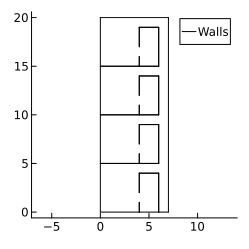

In [11]:
plot(size=(250, 250), aspect_ratio=:equal, grid=false)
plot!(walls, c=:black, label="Walls")

### Add goal object to environment

In [12]:
includet("KidnappedRobot/box.jl") # get `box_segments`, which draws a box out of line segments

# Coordinates for where to place goal object in the map we loaded above
GOAL = [1., 7.]

goalobj = box_segments(GOAL);

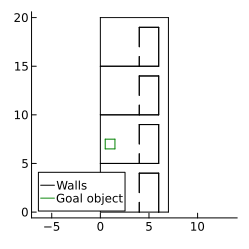

In [13]:
plot(size=(250, 250), aspect_ratio=:equal, grid=false, legend=:bottomleft)
plot!(walls, c=:black, label="Walls")
plot!(goalobj, c=:green, label="Goal object")

### Ground truth world parameters

In [14]:
### Ground truth world model parameters ###
PARAMS = (;
    map = vcat(walls, goalobj),      # The map consists of the walls, and the goal object
    p_kidnapped = 0.,                # Probability the agent is kidnapped on any given step
    bounding_box = bounding_box,     # Bounding box for the environment
    step = (; Δ = 0.25, σ = 0.005 ), # step model arguments
    obs = (; fov = 2π, n_rays = 80,  # obs model arguments
        orientation=π/2,
        sensor_args = (;
            w = 5, s_noise = 0.02,
            outlier = 0.0001, outlier_vol = 100.0,
            zmax = 100.0
)));

### Construct a particle filter

Next, we'll construct a 1-particle particle filter we can use for state estimation in this model.  It will be based on a proposal distribution which uses a coarse-to-fine sequence of grid scans over the 2D environment to precisely localize the agent.

In [15]:
### Particle Filter args ###

# pf.jl defines `@get_pf`.  This macro simply yields a call `GenPOMDPs.pf`, with the
# grid proposal distribution.
#
# `GenPOMDPs.pf` is a function which accepts a POMDP as input, and parameters controlling the
# behavior of a particle filter, and constructs a particle filter specialized to the shared structure
# of all POMDPs.
#
# `pf.jl` also defines some particle filtering proposal distributions based on
# coarse-to-fine grid scans.
includet("KidnappedRobot/pf.jl")

# Also load a file where I defined some default arguments for the particle filter
# proposal distributions.
includet("KidnappedRobot/default_pf_args.jl")

# Construct the POMDP the agent will use as it's mental world model while running inference.
# In this case, the mental-model GenPOMDP object will be the same as the ground-truth GenPOMDP object.
# However, the exact distributions represented by the mental-model POMDP and the ground-truth POMDP will
# be different, since we will give the agent a different set of parameters.
# (I could potentially refactor GenPOMDPs so that the GenPOMDP object contains the parameters within it,
# rather than the user passing this in each time.  That would also more precisely align with the
# formal definition of a POMDP.  However, I had in mind it may be convenient for other reasons
# to have an explicit `params` argument which can control details of the environment.)
agent_mental_model = GenPOMDPs.GenPOMDP(uniform_agent_pos, motion_model, sensor_model, (state, action) -> -1.)
# [We could just set agent_mental_model = pomdp; I write this out for illustrative purposes.]

# We will have the agent's mental model suppose the
# motion noise and observation noise are higher than
# they truly are, and the agent will do particle filtering
# assuming kidnapping is impossible.  (The controller will handle
# kidnapping by resetting the particle filter.)
MENTAL_MODEL_PARAMS = overwrite_params(
    PARAMS;
    p_kidnapped=0.,
    step=(; σ = 0.1),
    sensor_args=(; s_noise=0.1)
)

# Arguments for 1 particle SMC. [The resampling args don't do anything, since we're only using 1 particle here.]
update_grid_args, initialization_grid_args, resampling_args = default_pf_args(MENTAL_MODEL_PARAMS; n_particles=1)

# Particle filter for inference in the mental world model
pf = @get_pf(agent_mental_model, MENTAL_MODEL_PARAMS, update_grid_args, initialization_grid_args, resampling_args);

# The particle filter object returned by GenPOMDPs.pf is a pair of a function
# which initializes a particle filter, `initial_pf_state = pf_init(observation)`, and a function
# which updates the filter, `new_pf_state = pf_update(pf_state, action, new_observation)`.
(pf_init, pf_update) = pf;

In [16]:
# In inference, we'll use this generative function by constructing a ControlledTrajectoryModel.
# GenPOMDPs.RolloutModel(pomdp, controller)
ctm = GenPOMDPs.ControlledTrajectoryModel(agent_mental_model)
ctm isa Gen.GenerativeFunction

true

In [17]:
trace_of_mental_model = simulate(ctm,
    (
        3,                      # n timesteps to simulate
        [:left, :left, :left],  # action sequence
        MENTAL_MODEL_PARAMS     # parameters
    )
)
get_choices(trace_of_mental_model)

│
├── :init
│   │
│   ├── :state
│   │   │
│   │   └── :pos : [2.0441463714441452, 14.379857545951442]
│   │
│   └── :obs
│       │
│       └── :obs : [[-4.405687827430741, -1.6875518099385494], [99.92409868494954, -0.040220762990874626], [100.02536418844792, 0.12109853814890098], [-4.334427375343855, -3.1983556640912134], [-3.618285148696694, -1.9953254122833937], [-4.431509560799435, -1.0559114752793235], [-4.328298027261328, -0.7460362476446084], [-3.7209910813091867, -1.8257205445087805], [-4.31297610602789, -3.227843231546306], [-2.0657546226570265, -2.130168230914602], [-4.340869299924626, -3.2805725442722196], [-0.7780805497446603, -1.9282215547846278], [-1.4965494858265211, -1.9619609372942808], [-0.7161889703737983, -1.9221671730200531], [-1.831589781590845, -1.8181808038296423], [-0.8958179631886308, -1.9468497281895474], [-0.029365295341631986, -5.004337845197513], [-0.7264244062550329, -1.8733006247375823], [-0.7541126848963148, -1.802055712914709], [-0.5225771381713002, -2

## Baseline controller

As a baseline, we'll implement a controller which does state estimation without a particle filter; it will simply do a coarse-to-fine grid scan over the entire map to localize globally at every timestep.

To implement this, we'll simply use the `pf_init` function we obtained above when constructing our particle filter.  That is, we will construct a 1-particle filter at every timestep, as though each new observation is the first observation.

For planning, we'll do A* search in a discretized version of the environment.  To do this, our first step will be to construct a "GridWorld" environment, by overlaying a cartesian grid onto the continuous environment, and noting which squares in the grid are occupied by walls.

In [18]:
includet("KidnappedRobot/astar_planning.jl") # Loads: `find_action_using_grid_search`, `taxi_dist`, `get_planning_params`

# Generate a gridworld version of this environment, in which A* planning is feasible.
planning_params = get_planning_params(walls, bounding_box);

Then, we'll define the controller.

In [19]:
includet("KidnappedRobot/handle_sticking.jl") # Loads: `handle_sticking` [see below]

@gen function _baseline_controller(controller_state, obs)
    (prev_pf_state, prev_action) = controller_state

    # Do a global localization scan, based on the current timestep's observation alone.
    # Ignore any past inferences.
    pf_state = pf_init(choicemap((:obs, obs)))

    # Plan a trajectory to the goal in that grid contained in `planning_params`, using A*.
    # Return the first action of that plan.
    action = find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)

    # Sometimes, the details of the motion model and the A* planning
    # can cause the agent to "stick" on the walls.
    # This `handle_sticking` function checks if the agent has been trying
    # to perform the same action for multiple timesteps, but its belief state
    # has not changed; if so, it takes a random action orthogonal to the
    # action that is causing sticking.
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)

    return (action, (pf_state, prev_action)) # (action, next_controller_state)
end

baseline_controller = GenPOMDPs.Controller(
    _baseline_controller, # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)    # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_baseline_controller#709", Bool[0, 0], false), (nothing, nothing))

Now that we have defined the controller, we can get a Generative Function over trajectories from rolling out the true world model, using this controller to choose actions.

The arguments to this generative function are `T`, the number of timesteps to roll out, and the POMDP parameters.

In [20]:
baseline_rollout_model = GenPOMDPs.RolloutModel(pomdp, baseline_controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#778"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

Now let's simulate from this model.

First, we'll generate just the initial timestep.

In [21]:
# Start the agent off in a hallway.
INITIAL_POS = [6.5, 4*5 - 2];

┌ Info: Saved animation to /tmp/jl_kdcr6dutcD.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_kdcr6dutcD.gif")
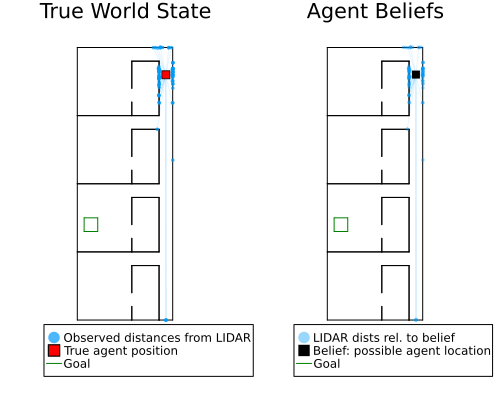

In [22]:
baseline_rollout_tr = Gen.generate(baseline_rollout_model,  # Generate a rollout...
    (0, PARAMS),                                            # ...up to time 0 [the initial timestep, generating an initial state, observation, and action]
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS)) # ...and constrain the rollout so that the initial state of the world places the agent at INITIAL_POS
)[1];

trace_to_gif(baseline_rollout_tr; goalobj=goalobj) # Visualize the rollout [as an image, as it is currently just 1 timestep].

Now, we'll have the model simulate behavior for 100 timesteps.

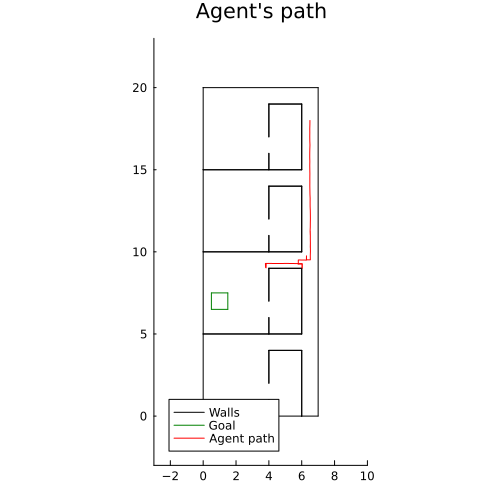

In [23]:
baseline_rollout_tr, _ = Gen.update(baseline_rollout_tr,  # Update the record of the rollout...
    (100, PARAMS),                                        # ...updating it to a rollout of 100 steps, with the same PARAMS as before...
    (UnknownChange(), NoChange()),                        # ...noting that the time argument changed, and the params didn't
                                                          #    (so Gen knows not to revisit every choice depending on PARAMS)...
    EmptyChoiceMap()                                      # Don't constrain any of the randomness in the roll-out.
                                                          # (In principle, we could use this last argument to constrain either environmental
                                                          # randomness, or random choices made by the controller in the roll-out.)
)

# Visualize the path the agent took.
trace_to_path_image(baseline_rollout_tr; goalobj=goalobj)

Here's a video of the agent's position and belief, over time.

┌ Info: Saved animation to /tmp/jl_qb4lMBsPWp.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_qb4lMBsPWp.gif")
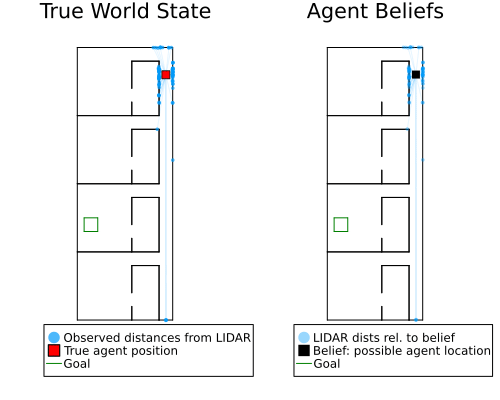

In [24]:
trace_to_gif(baseline_rollout_tr; goalobj=goalobj, fps=10)

The issue with this controller is that it does not remember its belief from the last timestep; it tries to fully relocalize at every step just using its current observations.

The result is that when the agent moves into a hallway into one of the rooms (which looks just like the hallways that lead into each other room), the agent gets confused about where it is. The issue is that the observed data from that timestep alone does not dis-ambiguate where the object is.  At each timestep it thinks it is in the hallway toward the goal, it takes a step into the room; at each timestep it thinks it is in another hallway, it takes a step out from the room.  As a result, it keeps going back and forth, and is stuck!

## Baseline particle-filtering controller

To fix this, let's use a controller which uses a 1-particle particle filter, rather than re-localizing at each timestep.

In [25]:
@gen function _baseline_pf_controller(controller_state, obs)
    (prev_pf_state, prev_action) = controller_state

    if isnothing(prev_pf_state)
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        pf_state = pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
    end

    action = find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)
    
    return (action, (pf_state, action)) # (action, next_controller_state)
end

baseline_pf_controller = GenPOMDPs.Controller(
    _baseline_pf_controller, # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)       # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_baseline_pf_controller#1208", Bool[0, 0], false), (nothing, nothing))

In [26]:
baseline_pf_rollout_model = GenPOMDPs.RolloutModel(pomdp, baseline_pf_controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1277"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_STW54HgPQ5.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_STW54HgPQ5.gif")
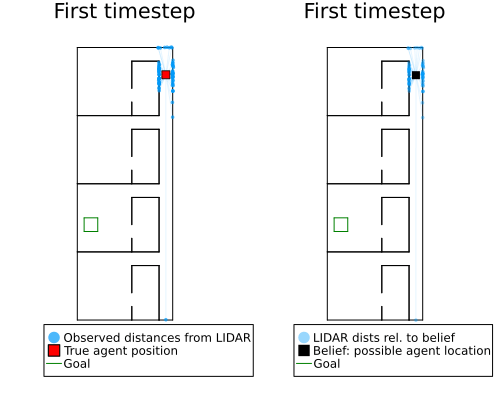

In [27]:
baseline_pf_rollout_tr = Gen.generate(baseline_pf_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(baseline_pf_rollout_tr; goalobj=goalobj, title="First timestep")

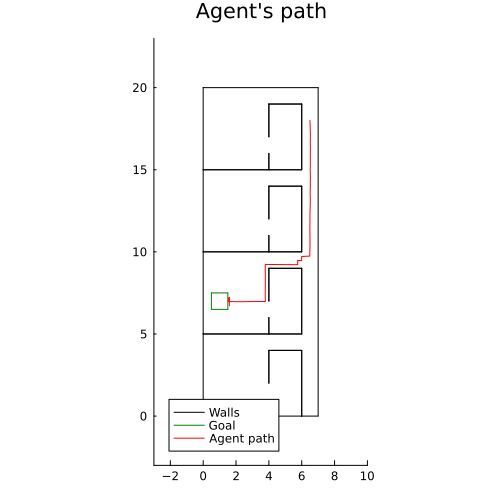

In [28]:
baseline_pf_rollout_tr, _ = Gen.update(baseline_pf_rollout_tr, (100, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap())

trace_to_path_image(baseline_pf_rollout_tr; goalobj=goalobj)

┌ Info: Saved animation to /tmp/jl_etGps5Klq7.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_etGps5Klq7.gif")
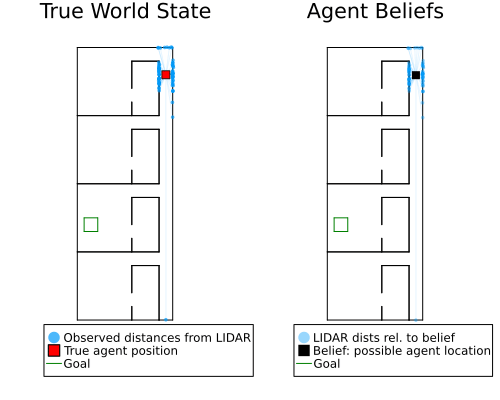

In [29]:
trace_to_gif(baseline_pf_rollout_tr; goalobj=goalobj, fps=10)

## "Kidnap the robot"

Now, we'll give the robot the same task: navigate to the green square.

But, after 40 timesteps, we'll imagine the robot comes across a well-meaning hotel employee who sees the robot, and doesn't realize we roboticists have it doing an important task for us.  The employee turns off the employee and brings it to a storage closet in one of the unoccupied hotel rooms.  Eventually, we notice this issue, and we turn the robot back on.  The robot controller then tries to pick up where it left off, and find a path to the goal.  But with the basic PF controller we defined above, the robot cannot re-localize after it is moved to a new place!

┌ Info: Saved animation to /tmp/jl_AVcZWFY9kF.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_AVcZWFY9kF.gif")
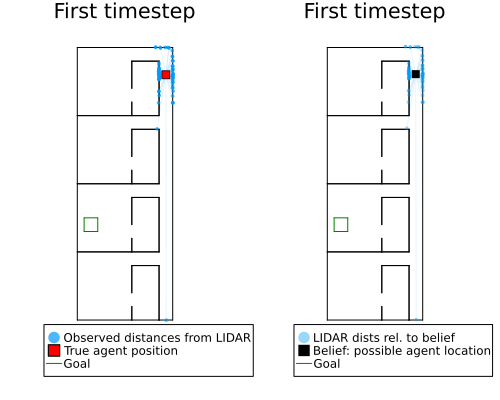

In [30]:
baseline_rollout_tr_KR = Gen.generate(baseline_pf_rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(baseline_rollout_tr_KR; goalobj=goalobj, title="First timestep")

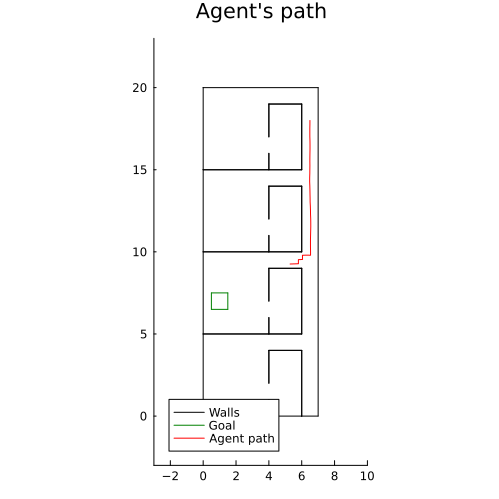

In [31]:
# Extend rollout to 40 steps...
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj)

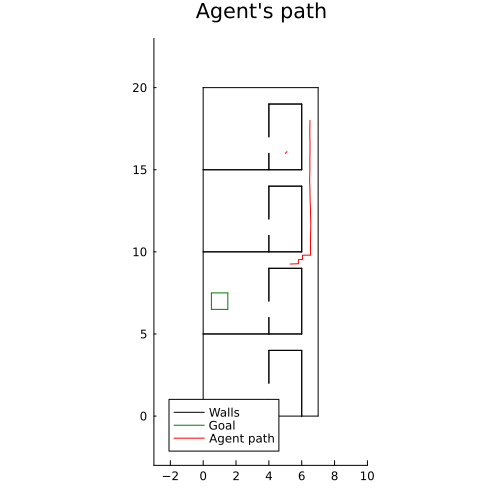

In [32]:
## Kidnap the robot!
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (41, PARAMS), (UnknownChange(), NoChange()),
    choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.]))
);

trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

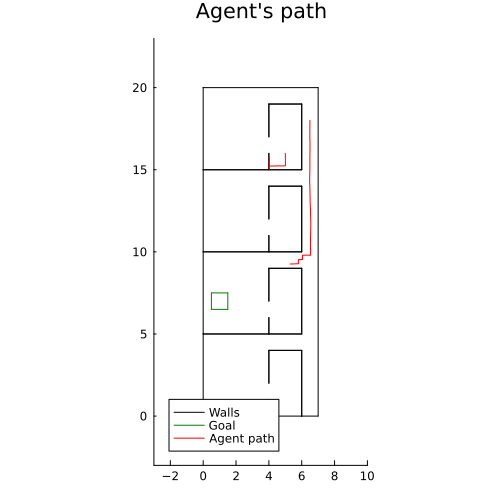

In [33]:
# Roll out the trace another 100 steps, after the robot is re-activated.
baseline_rollout_tr_KR, _ = Gen.update(baseline_rollout_tr_KR, (140, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());
trace_to_path_image(baseline_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

┌ Info: Saved animation to /tmp/jl_obmH4JotW9.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_obmH4JotW9.gif")
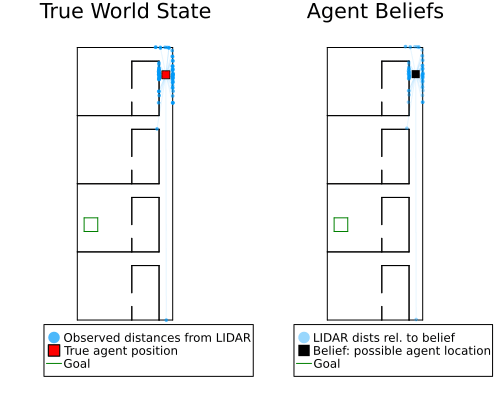

In [34]:
trace_to_gif(baseline_rollout_tr_KR; goalobj=goalobj, fps=10, kidnapped_at=[41])

The particle filter can't handle the robot kidnapping.

One solution would be to have the agent do expensive MCMC rejuvenation at every step, to check if it might have been moved elsewhere.

But we don't need to take on this computational cost.  Instead, we can have the controller make intelligent decisions about on which steps we should spend more computation to re-localize globally.

Below, we'll implement a simple version of this, which resets the particle filter whenever the marginal likelihood estimate from the particle filter (the average particle weight -- and in this case the only particle weight) falls too low.

## Robust controller: particle filtering + reset particle filter when the likelihood falls too low

In [35]:
# @dist labeled_categorical(labels, probs) = labels[categorical(probs)]

In [36]:
@gen function _controller(controller_state, obs)
    prev_pf_state, prev_action = controller_state
    
    # Create 1-particle belief state
    if isnothing(prev_action) # First timestep
        pf_state = pf_init(choicemap((:obs, obs)))
    else
        # Log marginal likelihood estimate from the particle filter
        prev_lml_est = GenParticleFilters.get_lml_est(prev_pf_state)

        # Try updating the PF belief state
        pf_state = pf_update(prev_pf_state, prev_action, choicemap((:obs, obs)))
        new_lml_est = GenParticleFilters.get_lml_est(pf_state)

        # We will define and tune this check below
        if incremental_log_likelihood_est_is_too_low(new_lml_est - prev_lml_est)
            # Reset the particle filter!
            # The new pf_state will be over trajectories of length 1.
            pf_state = pf_init(choicemap((:obs, obs)))
        end
    end
    
    # Choose action
    action = find_action_using_grid_search(planning_params, currentpos(pf_state.traces[1]), GOAL)
    action = handle_sticking(prev_pf_state, prev_action, pf_state, action)
    
    # Choose the action to take.
    # is_viable_onehot = [a in viable_actions ? 1. : 0 for a in [:left, :right, :up, :down, :stay]]
    # action_probs = is_viable_onehot / sum(is_viable_onehot)
    # action ~ labeled_categorical([:left, :right, :up, :down, :stay], action_probs)

    return (action, (pf_state, action)) # (action, next_controller_state)
end

controller = GenPOMDPs.Controller(
    _controller,                     # Controller state, observation ⇝ action, next controller state
    (nothing, nothing)               # Initial controller state
)

GenPOMDPs.Controller(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##_controller#1901", Bool[0, 0], false), (nothing, nothing))

**Tuning the particle filter log marginal likelihood threshold.**

Now, we need to define `incremental_log_likelihood_est_is_too_low`, which we used in the controller above.
This will be a simple threshold on the estimated value of `P(obs | latent_{t-1})` from the particle filter.

Note that the expected value of `P(obs)` is `P(obs | latent)`.  Based on this observation, we will set our threshold by generating 1000 random (latent, obs) pairs from the model, and setting the threshold to be the minimum value of `P(obs | latent)` which arises.

This is currently just a heuristic I quickly thought of to set this threshold, which I have observed works well in this environment.  One of my research TODOs is to think more carefully about about whether this method of tuning the threshold can be expected to work well across environments.

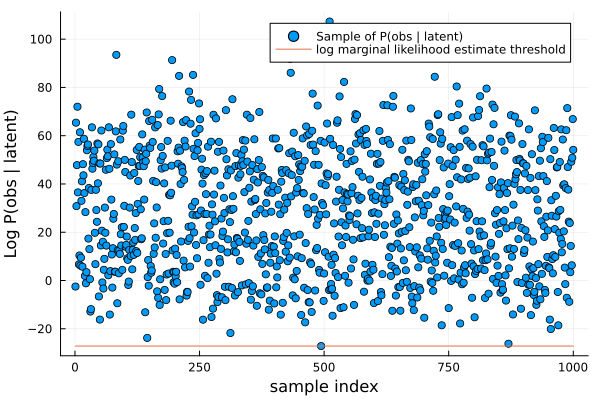

In [37]:
logpy_values = []
for _=1:1000
    state = uniform_agent_pos(MENTAL_MODEL_PARAMS)
    obs_tr = simulate(sensor_model, (state, MENTAL_MODEL_PARAMS))
    push!(logpy_values, get_score(obs_tr))
end

logpy_threshold = minimum(logpy_values)

function incremental_log_likelihood_est_is_too_low(incremental_logpy_estimate)
    return incremental_logpy_estimate < logpy_threshold
end

scatter(1:1000, logpy_values, ylabel="Log P(obs | latent)", xlabel="sample index", label="Sample of P(obs | latent)")
plot!(1:1000, [logpy_threshold for _=1:1000], label="log marginal likelihood estimate threshold")

**Simulating the robust controller, in an environment with no robot kidnapping.**

In [38]:
rollout_model = GenPOMDPs.RolloutModel(pomdp, controller)

GenPOMDPs.var"##StaticGenFunction__RolloutModel#1971"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

┌ Info: Saved animation to /tmp/jl_iNgF4vOX21.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_iNgF4vOX21.gif")
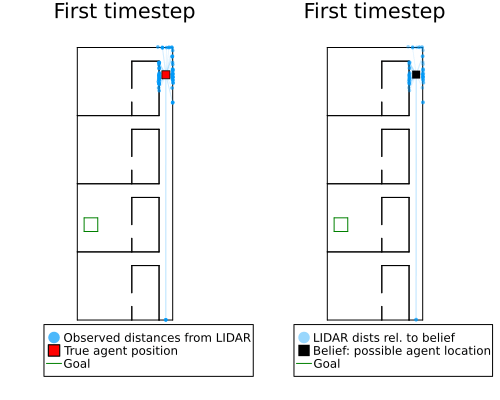

In [43]:
rollout_tr = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(rollout_tr; goalobj=goalobj, title="First timestep")

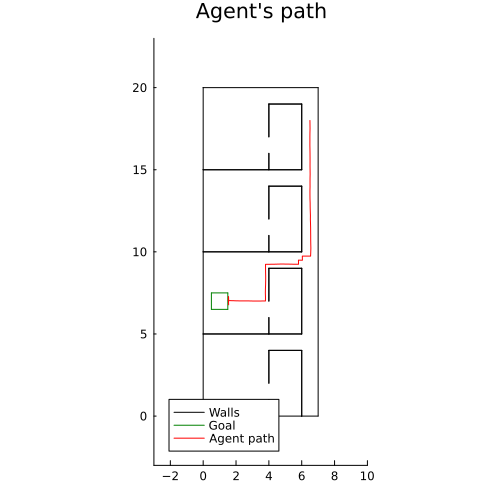

In [44]:
# Extend rollout...
rollout_tr, _ = Gen.update(rollout_tr, (80, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(rollout_tr; goalobj=goalobj)

┌ Info: Saved animation to /tmp/jl_8BIlKn8lcP.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_8BIlKn8lcP.gif")
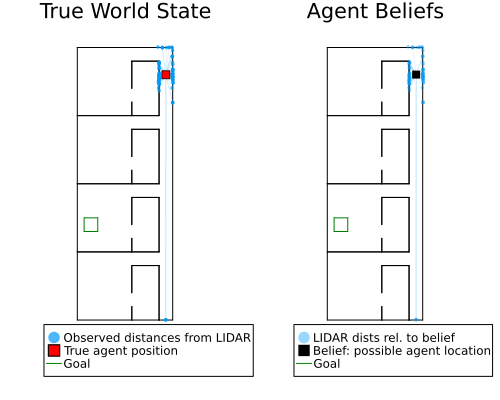

In [45]:
trace_to_gif(rollout_tr; goalobj=goalobj, fps=10)

### Kidnapped robot with the robust controller

┌ Info: Saved animation to /tmp/jl_wfaZwnYxep.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_wfaZwnYxep.gif")
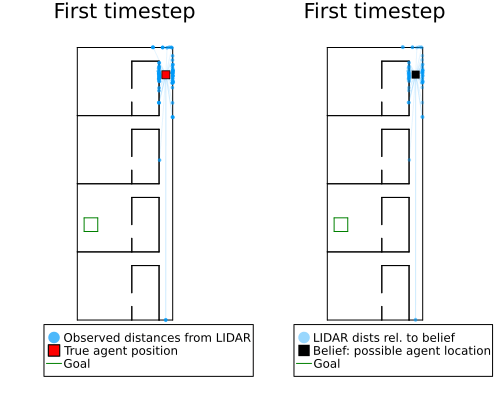

In [46]:
robust_rollout_tr_KR = Gen.generate(rollout_model, (0, PARAMS), 
    choicemap((GenPOMDPs.state_addr(0, :pos), INITIAL_POS))
)[1]

trace_to_gif(robust_rollout_tr_KR; goalobj=goalobj, title="First timestep")

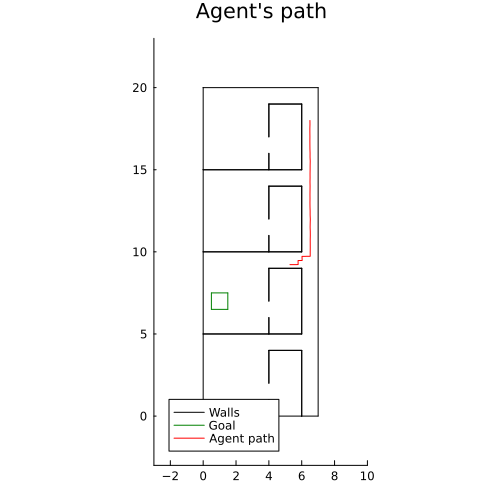

In [47]:
# Extend rollout to 40 steps...
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (40, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());

trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj)

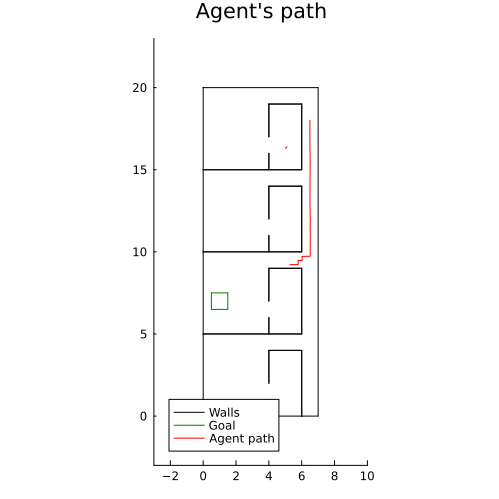

In [48]:
## Kidnap the robot!
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (41, PARAMS), (UnknownChange(), NoChange()),
    choicemap((GenPOMDPs.state_addr(41, :is_kidnapped), true), (GenPOMDPs.state_addr(41, :pos), [5., 16.3]))
);

trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

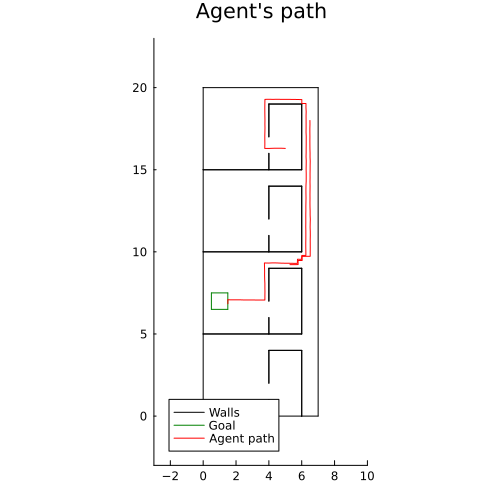

In [49]:
# Roll out the trace another 100 steps
robust_rollout_tr_KR, _ = Gen.update(robust_rollout_tr_KR, (140, PARAMS), (UnknownChange(), NoChange()), EmptyChoiceMap());
trace_to_path_image(robust_rollout_tr_KR; goalobj=goalobj, kidnapped_at=[41])

┌ Info: Saved animation to /home/ubuntu/Developer/tasks2D/notebooks_clean/kidnapping_recovery.gif.gif
└ @ Plots /home/ubuntu/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/home/ubuntu/Developer/tasks2D/notebooks_clean/kidnapping_recovery.gif.gif")
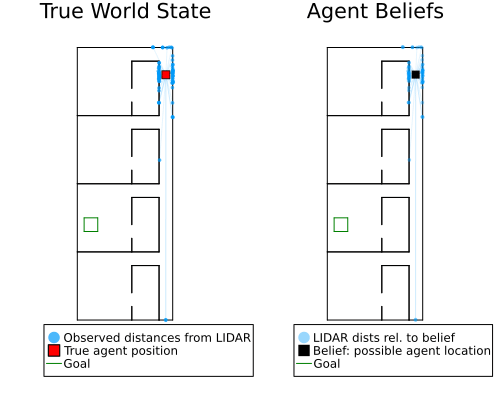

In [50]:
trace_to_gif(robust_rollout_tr_KR; goalobj=goalobj, fps=10, kidnapped_at=[41], saveas="kidnapping_recovery.gif")

**Plotting the log marginal likelihood estimates from each timestep:**

141


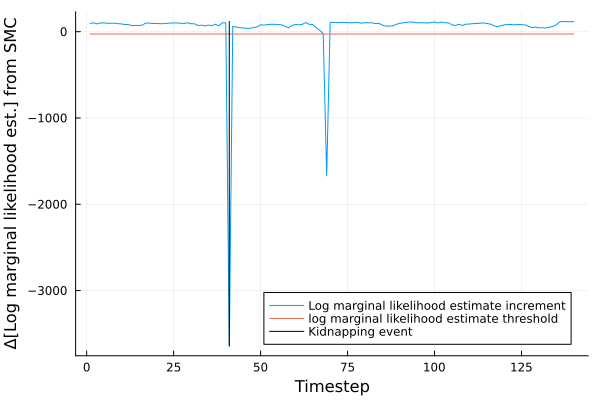

In [51]:
lml_ests = [GenParticleFilters.get_lml_est(pfst)
    for (pfst, _) in GenPOMDPs.controllerstate_sequence(robust_rollout_tr_KR)
]
println(length(lml_ests))
deltas = [x - y for (x, y) in zip(lml_ests[2:end], lml_ests[1:end-1])]
p = plot(1:length(deltas), deltas, label="Log marginal likelihood estimate increment", xlabel="Timestep", ylabel="Δ[Log marginal likelihood est.] from SMC")
plot!(1:length(deltas), [logpy_threshold for _ in 1:length(deltas)], label="log marginal likelihood estimate threshold")
plot!([41, 41], [minimum(deltas)-.1, maximum(deltas)+.1], label="Kidnapping event", c=:black)

## Plotting the runtime and effectiveness of each controller

In [53]:
includet("KidnappedRobot/measure_performance.jl") # Loads `take_measurement`, `take_measurement_KR`

In [54]:
robust_costs_runtimes = [take_measurement(rollout_model) for _=1:10];

In [55]:
baseline1_costs_runtimes = [take_measurement(baseline_rollout_model) for _=1:10];

In [56]:
baselinepf_costs_runtimes = [take_measurement(baseline_pf_rollout_model) for _=1:10];

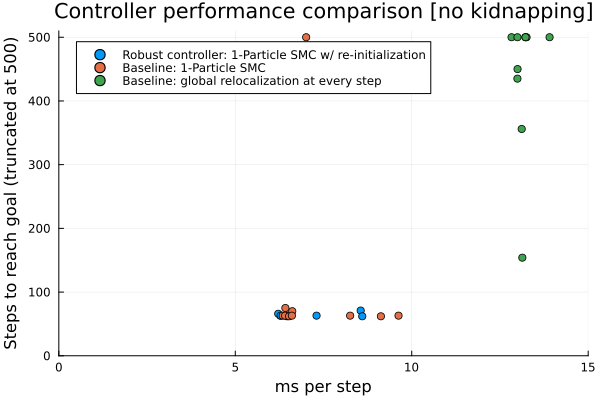

In [57]:
plot(;
    title="Controller performance comparison [no kidnapping]",
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15)
)
scatter!(map(x->x[2]*1000, robust_costs_runtimes), map(x->x[1], robust_costs_runtimes), label="Robust controller: 1-Particle SMC w/ re-initialization")
scatter!(map(x->x[2]*1000, baselinepf_costs_runtimes), map(x->x[1], baselinepf_costs_runtimes), label="Baseline: 1-Particle SMC")
scatter!(map(x->x[2]*1000, baseline1_costs_runtimes), map(x->x[1], baseline1_costs_runtimes), label="Baseline: global relocalization at every step")

In [58]:
robust_costs_runtimes_KR = [take_measurement_KR(rollout_model) for _=1:10];

In [59]:
baseline1_costs_runtimes_KR = [take_measurement_KR(baseline_rollout_model) for _=1:10];

In [60]:
baselinepf_costs_runtimes_KR = [take_measurement_KR(baseline_pf_rollout_model) for _=1:10];

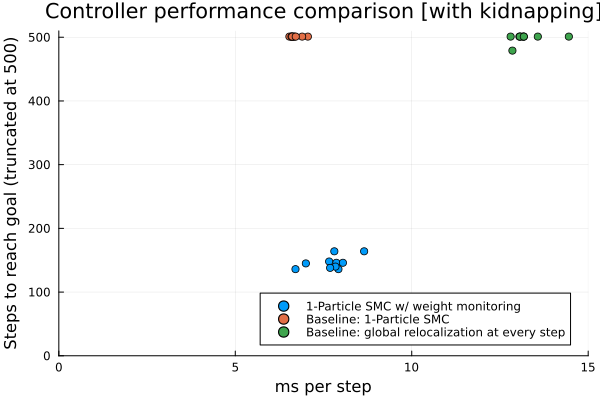

In [61]:
plot(;
    title="Controller performance comparison [with kidnapping]",
    ylabel="Steps to reach goal (truncated at 500)",
    xlabel="ms per step",
    ylims=(0, 510),
    xlims=(0,15),
    legend=:bottomright
)
scatter!(map(x->x[2]*1000, robust_costs_runtimes_KR), map(x->x[1], robust_costs_runtimes_KR), label="1-Particle SMC w/ weight monitoring")
scatter!(map(x->x[2]*1000, baselinepf_costs_runtimes_KR), map(x->x[1], baselinepf_costs_runtimes_KR), label="Baseline: 1-Particle SMC")
scatter!(map(x->x[2]*1000, baseline1_costs_runtimes_KR), map(x->x[1], baseline1_costs_runtimes_KR), label="Baseline: global relocalization at every step")